# Winter 2015-16
12/22/2015 - 3/20/2016

In [190]:
from __future__ import print_function

import random
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

In [191]:
#data = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_151219.txt')
#data= data.rename(columns=lambda x: x.strip())
week_list = ['151219','151226','160102','160109','160116','160123','160130',
             '160206','160213','160220','160227','160305','160312','160319']
weeks = []
for week in random.sample(week_list,4):
    string = 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_' + week + '.txt'
    weeks.append(pd.read_csv(string).rename(columns=lambda x: x.strip()))
    
data = pd.concat(weeks)
data = data.reset_index()

In [192]:
data.head()

,index,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,0,A002,R051,02-00-00,59 ST,NQR456,BMT,02/27/2016,03:00:00,REGULAR,5562172,1877574
1,1,A002,R051,02-00-00,59 ST,NQR456,BMT,02/27/2016,07:00:00,REGULAR,5562184,1877586
2,2,A002,R051,02-00-00,59 ST,NQR456,BMT,02/27/2016,11:00:00,REGULAR,5562267,1877691
3,3,A002,R051,02-00-00,59 ST,NQR456,BMT,02/27/2016,15:00:00,REGULAR,5562516,1877745
4,4,A002,R051,02-00-00,59 ST,NQR456,BMT,02/27/2016,19:00:00,REGULAR,5562920,1877821


In [193]:
data['DATETIME'] = pd.to_datetime(data.DATE + data.TIME, format='%m/%d/%Y%H:%M:%S')

In [194]:
data['HOUR'] = data.DATETIME.map(lambda x: x.hour)
data['PERIOD'] = data.HOUR // 4

In [195]:
data['dENTRIES'] = data.groupby(['C/A','UNIT','SCP','STATION']).ENTRIES.diff()
data['dEXITS'] = data.groupby(['C/A','UNIT','SCP','STATION']).EXITS.diff()

In [205]:
# Anything over 6000 is probably an error
data = data[data.dENTRIES >= 0]
data = data[data.dEXITS >= 0]
data = data[data.dENTRIES <= 5000]
data = data[data.dEXITS <= 5000]

data['FLUX'] = data.dENTRIES + data.dEXITS

In [206]:
data.describe()

,index,ENTRIES,EXITS,HOUR,PERIOD,dENTRIES,dEXITS,FLUX,LAT,LON
count,756490.000000,7.564900e+05,7.564900e+05,756490.000000,756490.000000,756490.00000,756490.000000,756490.000000,379834.000000,379834.000000
mean,97721.507898,2.382568e+07,1.746159e+07,11.680427,2.551936,181.45870,136.513658,317.972358,40.735113,-73.960191
std,56381.806467,1.472037e+08,1.239377e+08,6.814452,1.666976,282.60845,249.069398,432.011883,0.059835,0.061632
min,1.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,40.576152,-74.155533
25%,48873.250000,5.617185e+05,2.882660e+05,7.000000,1.000000,10.00000,8.000000,31.000000,40.706636,-73.998381
50%,97701.000000,2.466406e+06,1.446812e+06,12.000000,3.000000,74.00000,48.000000,164.000000,40.734836,-73.981826
75%,146471.000000,6.238789e+06,4.427676e+06,17.000000,4.000000,242.00000,159.000000,450.000000,40.757400,-73.937452
max,200833.000000,2.146697e+09,2.097164e+09,23.000000,5.000000,4999.00000,4999.000000,9849.000000,40.893386,-73.755383


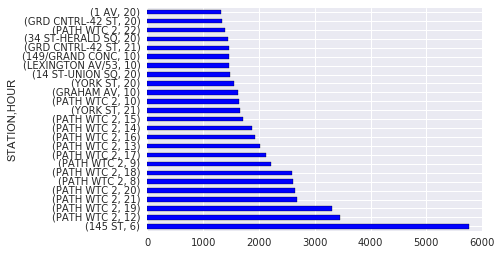

In [210]:
times = data.groupby(['STATION','HOUR']).mean()
times.FLUX.sort_values(ascending=False)[:25].plot.barh()

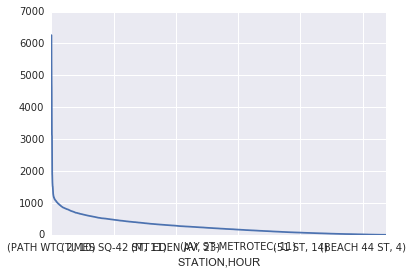

In [199]:
times = data.groupby(['STATION','HOUR']).median()
times.FLUX.sort_values(ascending=False).plot.line()

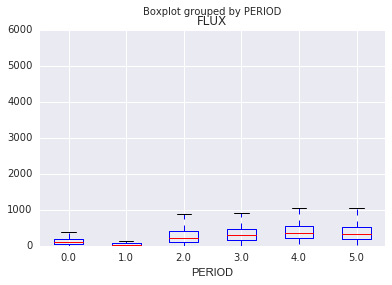

In [208]:
times.boxplot(column='FLUX',by='PERIOD')

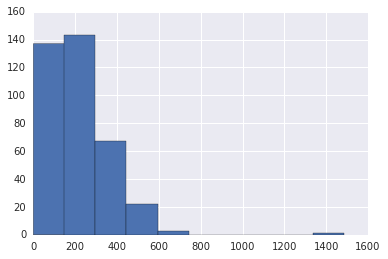

In [201]:
data.groupby('STATION').FLUX.median().hist()

In [202]:
geo_names = ['UNIT','C/A','STATION','X','DIVISION','LAT','LON']
geocodes = pd.read_csv('geocoded.csv', names = geo_names)
geocodes = geocodes.drop('X',1)
geocodes.head()

,UNIT,C/A,STATION,DIVISION,LAT,LON
0,R470,X002,ELTINGVILLE PK,SRT,40.544600,-74.164581
1,R544,PTH02,HARRISON,PTH,40.738879,-74.155533
2,R165,S102,TOMPKINSVILLE,SRT,40.636948,-74.074824
3,R070,S101,ST. GEORGE,SRT,40.643738,-74.073622
4,R070,S101A,ST. GEORGE,SRT,40.643738,-74.073622


In [203]:
data = pd.merge(data,geocodes,how='left',on=['C/A','UNIT','STATION','DIVISION'])

In [204]:
import gmaps

geodata = data.as_matrix(columns=['LON','LAT','FLUX'])
#maps = gmaps.heatmap(geodata)
#gmaps.display(map)
geodata

array([[        nan,         nan,   24.      ],
       [        nan,         nan,  188.      ],
       [        nan,         nan,  303.      ],
       ..., 
       [ -73.954006,   40.7574  ,    0.      ],
       [ -73.954006,   40.7574  ,    0.      ],
       [ -73.954006,   40.7574  ,    0.      ]])